In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt
from scipy.stats import chi2_contingency
from wordcloud import WordCloud
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

In [2]:
os.chdir(r"E:\PYTHON PROJECTS")
print(os.getcwd())

E:\PYTHON PROJECTS


In [3]:
# read csv file into a DataFrame, set the delimiter as semicolon and exclude the header row

df = pd.read_csv('sanction.csv', sep=';', header=None, skiprows=1)
df[2] = df.apply(lambda row: row[2].split(';')[0].strip('"'), axis=1)
df.columns = ['sport', 'substance_reason', 'sanction_terms', 'sanction_announced']
df.head(10)

,sport,substance_reason,sanction_terms,sanction_announced
0,Cycling,Androgenic Anabolic Steroid,4-Year Suspension,08/11/2021
1,Weightlifting,Stanozolol,4-Year Suspension,08/11/2021
2,Pentathlon,Ostarine; LGD?4033; GW1516,6-Year Suspension,08/06/2021
3,Mixed Martial Arts,Cocaine,1-Month Suspension,07/29/2021
4,Track and Field,Cannabinoids,1-Month Suspension,07/02/2021
5,Weightlifting,Dehydrochloromethyltestosterone (DHCMT),4-Year Suspension,07/01/2021
6,Paralympic Track and Field,Ostarine; LGD?4033,12-Month Suspension,06/29/2021
7,Mixed Martial Arts,Stanozolol,18-Month Suspension,06/16/2021
8,Paralympic Judo,Non-Analytical: Refusal to Submit to Sample Co...,4-Year Suspension,06/16/2021
9,Weightlifting,Oxymetholone; Dehydrochloromethyltestosterone ...,4-Year Suspension,06/03/2021


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 829 entries, 0 to 828
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   sport               829 non-null    object
 1   substance_reason    829 non-null    object
 2   sanction_terms      829 non-null    object
 3   sanction_announced  592 non-null    object
dtypes: object(4)
memory usage: 26.0+ KB


In [5]:
df.isnull().sum()

sport                   0
substance_reason        0
sanction_terms          0
sanction_announced    237
dtype: int64

In [6]:
df.duplicated().sum()

50

In [7]:
df.dropna(inplace=True)

In [8]:
df.drop_duplicates(inplace=True)

In [9]:
df.shape

(585, 4)

In [10]:
df.tail(5)

,sport,substance_reason,sanction_terms,sanction_announced
655,Cycling,Cathine (Norpseudoephedrine),Public Warning - Loss of Results,10/13/2004
657,Track and Field,Ephedrine,Public Warning - Loss of Results,10/17/2002
658,Cycling,"Phentermine, Boldenone and Nandrolone",1-Year Suspension - Loss of Results,08/30/2002
660,Cycling,Elevated T/E,1-Year Suspension - Loss of Results,07/18/2002
662,Track and Field,19-norandrosterone (19-NA)and 19-noretiocholan...,Lifetime Suspension - Loss of Results,09/17/2001


In [11]:
for col in df.columns:
    print(col, ':', df[col].nunique())

sport : 64
substance_reason : 242
sanction_terms : 86
sanction_announced : 547


In [12]:
sport_counts = df['sport'].value_counts()
sport_counts.head(15)

Cycling                                        118
Mixed Martial Arts                             112
Weightlifting                                  103
Track and Field                                 91
Triathlon                                       13
Wrestling                                       13
Paralympic Track and Field                       9
Swimming                                         9
Boxing                                           7
Taekwondo                                        6
Track and Field - Athlete Support Personnel      6
Brazilian Jiu-Jitsu                              6
Cycling - Athlete Support Personnel              6
Judo                                             5
Bobsled and Skeleton                             5
Name: sport, dtype: int64

In [13]:
substance_reason_counts = df['substance_reason'].value_counts()
substance_reason_counts.head(15)

Androgenic Anabolic Steroid                               46
Cannabinoids                                              36
Ostarine                                                  29
Non-Analytical: Refusal to Submit to Sample Collection    28
Non-Analytical: 3 Whereabouts Failures                    21
Methylhexaneamine                                         20
Clomiphene                                                15
Stanozolol                                                10
Non-Analytical                                             9
Furosemide                                                 8
Testosterone                                               7
Erythropoietin (EPO)                                       7
Non-Analytical: Possession and Use/Attempted Use           6
GW1516                                                     6
Canrenone                                                  6
Name: substance_reason, dtype: int64

In [14]:
# Drop rows containing 'Original' and 'Update' in the column 'sanction_announced'

df = df[~df['sanction_announced'].str.contains('Original|Update')]
df['sanction_announced'] = pd.to_datetime(df['sanction_announced'], format='%m/%d/%Y')
df['month'] = df['sanction_announced'].dt.strftime('%B')

df.head()

,sport,substance_reason,sanction_terms,sanction_announced,month
0,Cycling,Androgenic Anabolic Steroid,4-Year Suspension,2021-08-11,August
1,Weightlifting,Stanozolol,4-Year Suspension,2021-08-11,August
2,Pentathlon,Ostarine; LGD?4033; GW1516,6-Year Suspension,2021-08-06,August
3,Mixed Martial Arts,Cocaine,1-Month Suspension,2021-07-29,July
4,Track and Field,Cannabinoids,1-Month Suspension,2021-07-02,July


In [15]:
# Assuming that the date in the 'sanction_announced' column is of type datetime

df['year'] = df['sanction_announced'].dt.year
df.head(3)

,sport,substance_reason,sanction_terms,sanction_announced,month,year
0,Cycling,Androgenic Anabolic Steroid,4-Year Suspension,2021-08-11,August,2021
1,Weightlifting,Stanozolol,4-Year Suspension,2021-08-11,August,2021
2,Pentathlon,Ostarine; LGD?4033; GW1516,6-Year Suspension,2021-08-06,August,2021


In [16]:
df['year'].unique()

array([2021, 2020, 2019, 2018, 2017, 2016, 2015, 2014, 2013, 2012, 2011,
       2010, 2009, 2008, 2007, 2006, 2004, 2002, 2001], dtype=int64)

In [17]:
# Adding a new column ['sanction_terms_year'] which calculate years of sanctions terms.

import re

def calculate_sanction_terms_year(sanction_terms):
    year_regex = r'(\d+)-Year'
    month_regex = r'(\d+)[ -]Month'
    day_regex = r'(\d+)[ -]Day'

    if sanction_terms == 'Lifetime Suspension' or sanction_terms == 'Lifetime':
        return 70.000000
    elif re.search(year_regex, sanction_terms):
        return int(re.search(year_regex, sanction_terms).group(1))
    elif re.search(month_regex, sanction_terms):
        months = int(re.search(month_regex, sanction_terms).group(1))
        return months / 12
    elif re.search(day_regex, sanction_terms):
        days = int(re.search(day_regex, sanction_terms).group(1))
        return days / 365
    else:
        return 0

df['sanction_terms_year'] = df['sanction_terms'].apply(calculate_sanction_terms_year)
df.head()

,sport,substance_reason,sanction_terms,sanction_announced,month,year,sanction_terms_year
0,Cycling,Androgenic Anabolic Steroid,4-Year Suspension,2021-08-11,August,2021,4.000000
1,Weightlifting,Stanozolol,4-Year Suspension,2021-08-11,August,2021,4.000000
2,Pentathlon,Ostarine; LGD?4033; GW1516,6-Year Suspension,2021-08-06,August,2021,6.000000
3,Mixed Martial Arts,Cocaine,1-Month Suspension,2021-07-29,July,2021,0.083333
4,Track and Field,Cannabinoids,1-Month Suspension,2021-07-02,July,2021,0.083333


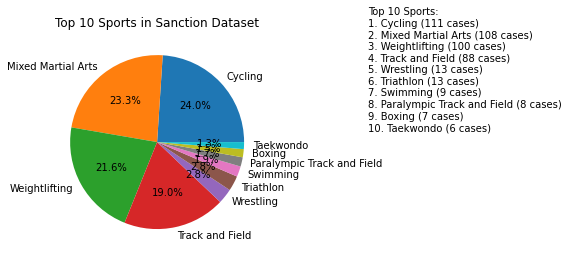

In [18]:
# Get the counts of each sport
# Get the top 10 sports and their counts

sport_counts = df['sport'].value_counts()
top_sports = sport_counts[:10]
top_sport_names = list(top_sports.index)
top_sport_counts = list(top_sports.values)


fig, ax = plt.subplots()
ax.pie(top_sport_counts, labels=top_sport_names, autopct='%1.1f%%')
ax.set_title('Top 10 Sports in Sanction Dataset')
text = 'Top 10 Sports:\n'
for i in range(len(top_sport_names)):
    text += f"{i+1}. {top_sport_names[i]} ({top_sport_counts[i]} cases)\n"

plt.figtext(1, 0.5, text)
plt.show()

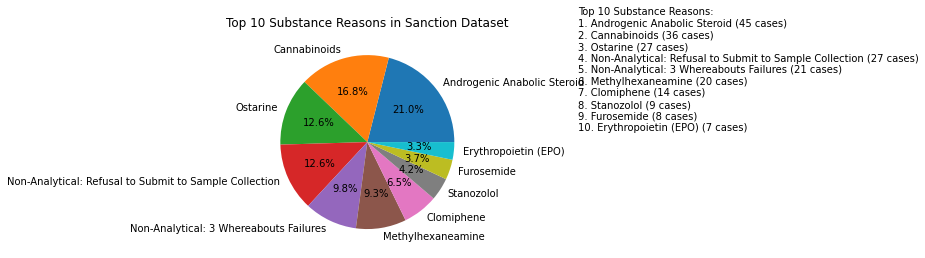

In [19]:
# Get the counts of each substance reason
# Get the top 10 substance reasons and their counts

reason_counts = df['substance_reason'].value_counts()
top_reasons = reason_counts[:10]
top_reason_names = list(top_reasons.index)
top_reason_counts = list(top_reasons.values)

fig, ax = plt.subplots()
ax.pie(top_reason_counts, labels=top_reason_names, autopct='%1.1f%%')
ax.set_title('Top 10 Substance Reasons in Sanction Dataset')

text = 'Top 10 Substance Reasons:\n'
for i in range(len(top_reason_names)):
    text += f"{i+1}. {top_reason_names[i]} ({top_reason_counts[i]} cases)\n"

plt.figtext(1, 0.5, text)
plt.show()

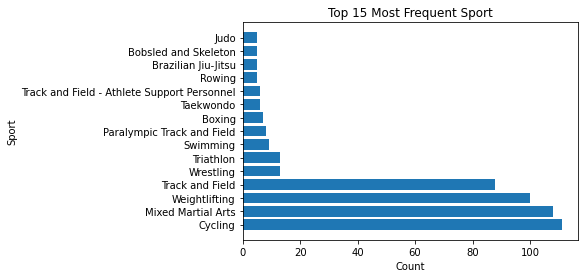

In [20]:
# get the value counts for the 'substance_reason' column
counts = df['sport'].value_counts()

n = 15
plt.barh(counts.index[:n], counts[:n])
plt.title('Top {} Most Frequent Sport'.format(n))
plt.xlabel('Count')
plt.ylabel('Sport')

plt.show()

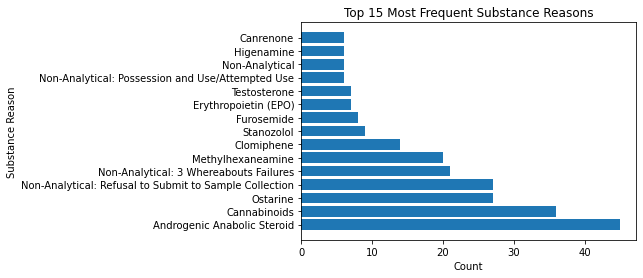

In [21]:
# get the value counts for the 'substance_reason' column
counts = df['substance_reason'].value_counts()

n = 15
plt.barh(counts.index[:n], counts[:n])
plt.title('Top {} Most Frequent Substance Reasons'.format(n))
plt.xlabel('Count')
plt.ylabel('Substance Reason')

plt.show()

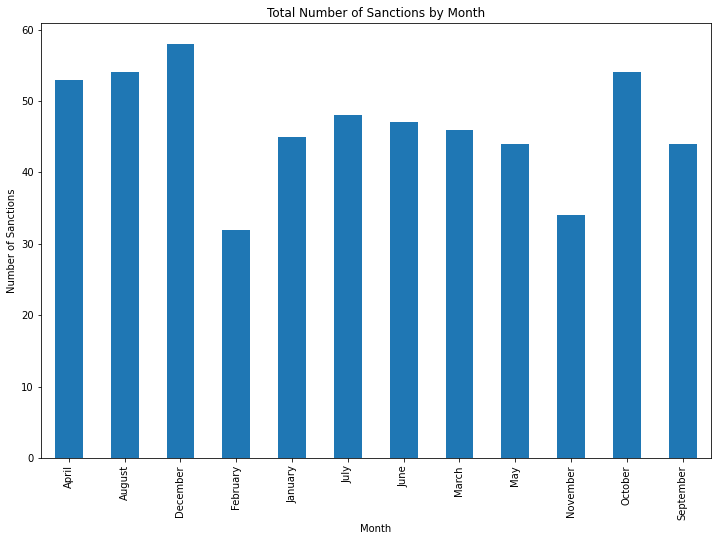

In [22]:
# Group the data by month and count the number of sanctions
sanctions_by_month = df.groupby('month')['sanction_announced'].count()

fig, ax = plt.subplots(figsize=(12, 8))
sanctions_by_month.plot(kind='bar', ax=ax)
ax.set_xlabel('Month')
ax.set_ylabel('Number of Sanctions')
ax.set_title('Total Number of Sanctions by Month')

plt.show()

In [26]:
df['month'].value_counts()

December     58
August       54
October      54
April        53
July         48
June         47
March        46
January      45
September    44
May          44
November     34
February     32
Name: month, dtype: int64

In [23]:
# create a contingency table of Sanction terms vs Substance reason
# perform chi-squared test

cont_table = pd.crosstab(df['sanction_terms'], df['substance_reason'])

chi2, p, dof, expected = chi2_contingency(cont_table)

print('Chi-Squared Test Results:')
print('==========================')
print('Chi-Squared Statistic: {:.4f}'.format(chi2))
print('Degrees of Freedom: {}'.format(dof))
print('P-value: {:.4f}'.format(p))
print('Expected Frequencies:\n', expected)

alpha = 0.05

if p <= alpha:
    print('\nThe p-value is less than or equal to the significance level.')
    print('There is evidence to reject the null hypothesis.')
else:
    print('\nThe p-value is greater than the significance level.')
    print('There is insufficient evidence to reject the null hypothesis.')

Chi-Squared Test Results:
Chi-Squared Statistic: 20488.4475
Degrees of Freedom: 17710
P-value: 0.0000
Expected Frequencies:
 [[0.00715564 0.02146691 0.00715564 ... 0.00715564 0.00715564 0.01431127]
 [0.00178891 0.00536673 0.00178891 ... 0.00178891 0.00178891 0.00357782]
 [0.04651163 0.13953488 0.04651163 ... 0.04651163 0.04651163 0.09302326]
 ...
 [0.00178891 0.00536673 0.00178891 ... 0.00178891 0.00178891 0.00357782]
 [0.04293381 0.12880143 0.04293381 ... 0.04293381 0.04293381 0.08586762]
 [0.019678   0.05903399 0.019678   ... 0.019678   0.019678   0.03935599]]

The p-value is less than or equal to the significance level.
There is evidence to reject the null hypothesis.


Chi-squared test shows a significant association between the two variables (in this case, sanction terms and substance reason), it means that there is evidence to suggest that they are not independent.

In [24]:
cont_table = pd.crosstab(df['sport'], df['substance_reason'])

chi2, p, dof, expected = chi2_contingency(cont_table)

print('Chi-Squared Test Results:')
print('==========================')
print('Chi-Squared Statistic: {:.4f}'.format(chi2))
print('Degrees of Freedom: {}'.format(dof))
print('P-value: {:.4f}'.format(p))
print('Expected Frequencies:\n', expected)

alpha = 0.05

if p <= alpha:
    print('\nThe p-value is less than or equal to the significance level.')
    print('There is evidence to reject the null hypothesis.')
else:
    print('\nThe p-value is greater than the significance level.')
    print('There is insufficient evidence to reject the null hypothesis.')

Chi-Squared Test Results:
Chi-Squared Statistic: 13844.0462
Degrees of Freedom: 14260
P-value: 0.9935
Expected Frequencies:
 [[0.00536673 0.01610018 0.00536673 ... 0.00536673 0.00536673 0.01073345]
 [0.00178891 0.00536673 0.00178891 ... 0.00178891 0.00178891 0.00357782]
 [0.00894454 0.02683363 0.00894454 ... 0.00894454 0.00894454 0.01788909]
 ...
 [0.17889088 0.53667263 0.17889088 ... 0.17889088 0.17889088 0.35778175]
 [0.00178891 0.00536673 0.00178891 ... 0.00178891 0.00178891 0.00357782]
 [0.02325581 0.06976744 0.02325581 ... 0.02325581 0.02325581 0.04651163]]

The p-value is greater than the significance level.
There is insufficient evidence to reject the null hypothesis.


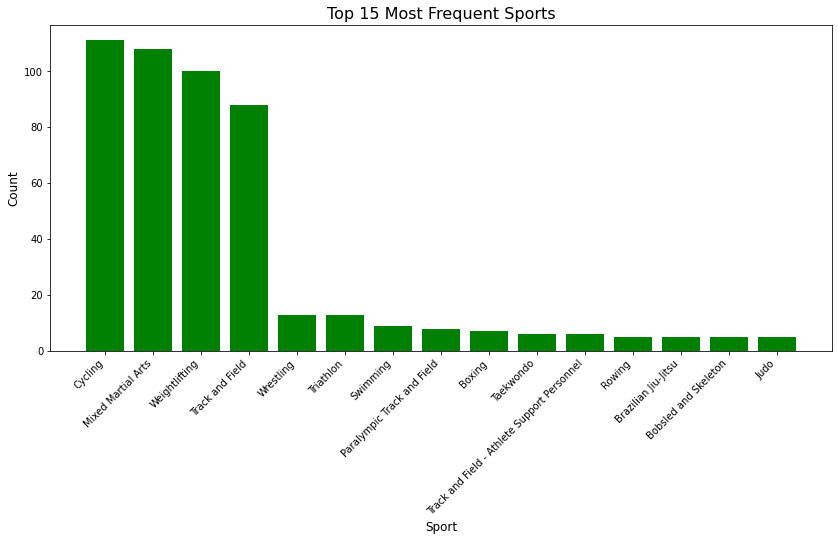

In [25]:
# get the value counts for the 'sport' column and select the top 15 values

top_sports = df['sport'].value_counts().nlargest(15)

fig, ax = plt.subplots(figsize=(14, 6))
ax.bar(top_sports.index, top_sports.values, color='green')
ax.set_title('Top 15 Most Frequent Sports', fontsize=16)
ax.set_xlabel('Sport', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')

plt.show()

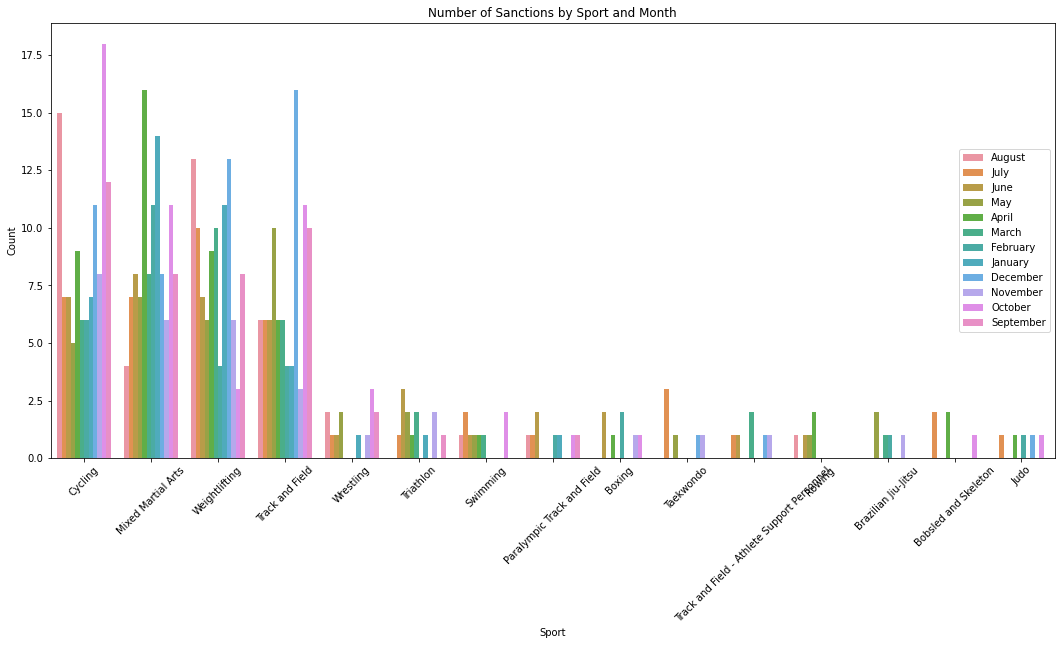

In [27]:
plt.figure(figsize=(18,8))
sns.countplot(x='sport', hue='month', data=df, order=df['sport'].value_counts().nlargest(15).index)
plt.title('Number of Sanctions by Sport and Month')
plt.xlabel('Sport')
plt.ylabel('Count')
plt.legend(loc='right')

plt.xticks(rotation=45)
plt.show()

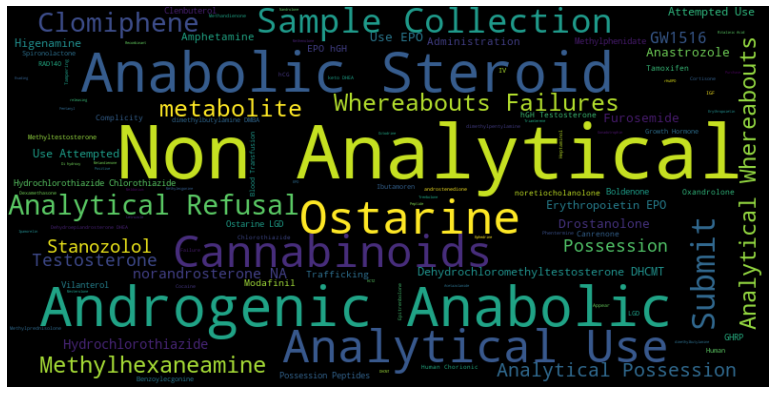

In [28]:
# create a string of all words in the dataset

all_words = ' '.join(df['substance_reason'])
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(all_words)

plt.figure(figsize=(14, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

plt.show()

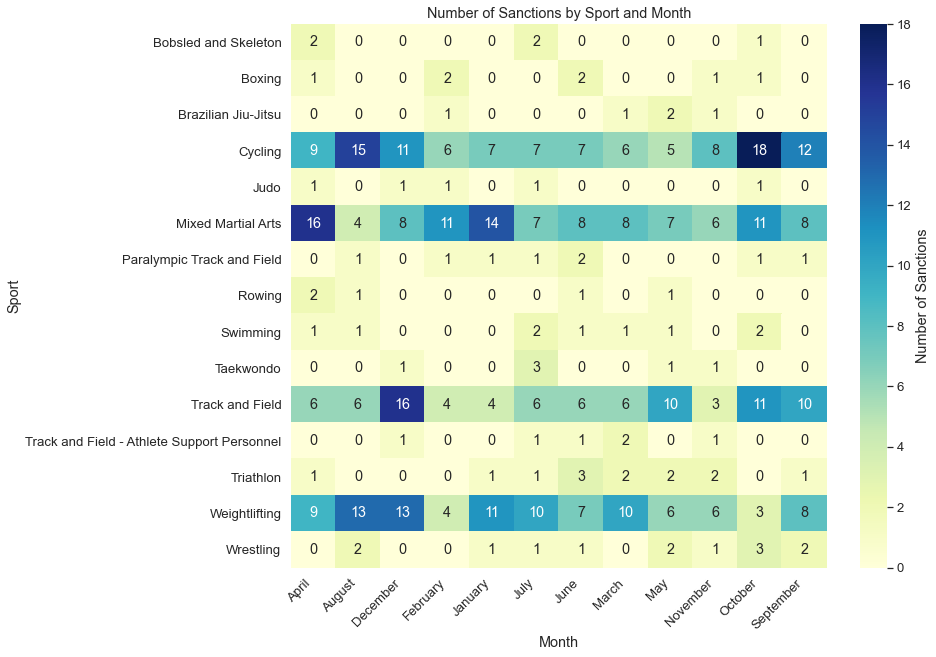

In [29]:
# Filter the top 15 sports by frequency

top_sports = df['sport'].value_counts().nlargest(15)
df_top = df[df['sport'].isin(top_sports.index)]

table = pd.pivot_table(df_top, 
                       values='sanction_announced', 
                       index='sport', 
                       columns='month', 
                       aggfunc=len, 
                       fill_value=0)

sns.set(font_scale=1.2)
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(table, 
            cmap='YlGnBu', 
            annot=True, 
            fmt='d', 
            cbar_kws={'label': 'Number of Sanctions'})
ax.set_xlabel('Month')
ax.set_ylabel('Sport')
ax.set_title('Number of Sanctions by Sport and Month')
plt.xticks(rotation=45, ha='right')

plt.show()

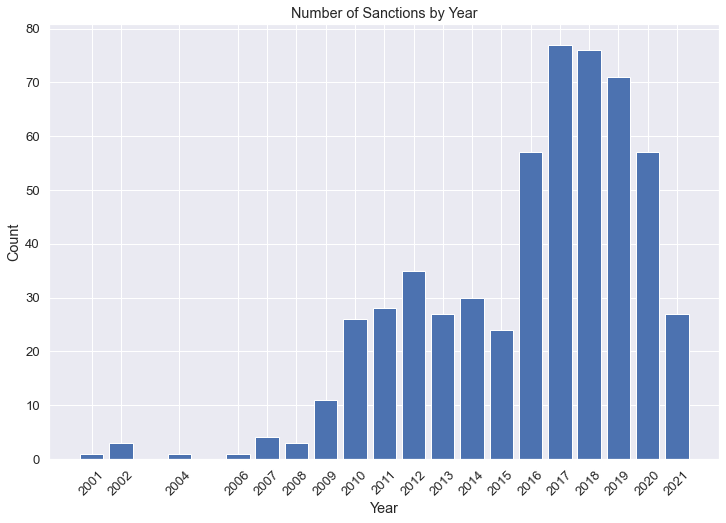

In [30]:
# count the number of sanctions per year

sanctions_per_year = df['year'].value_counts().sort_index()

fig, ax = plt.subplots(figsize=(12, 8))
ax.bar(sanctions_per_year.index, sanctions_per_year.values)
ax.set_title('Number of Sanctions by Year')
ax.set_xlabel('Year')
ax.set_ylabel('Count')
ax.set_xticks(sanctions_per_year.index)
plt.xticks(rotation=45)

plt.show()

In [31]:
df['sanction_terms_year'].value_counts().head(15)

2.000000     137
4.000000     114
1.000000      71
0.500000      65
0.000000      46
0.250000      18
0.750000      16
8.000000      12
1.500000      10
70.000000      9
1.333333       7
0.333333       6
1.666667       6
1.750000       5
3.000000       4
Name: sanction_terms_year, dtype: int64

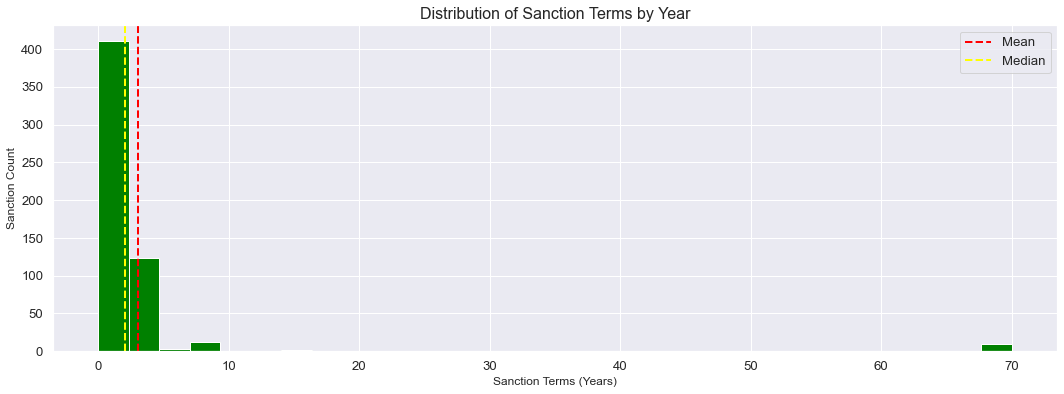

In [32]:
plt.figure(figsize=(18, 6))
plt.hist(df['sanction_terms_year'], bins=30, color='green')
plt.title('Distribution of Sanction Terms by Year', fontsize=16)
plt.xlabel('Sanction Terms (Years)', fontsize=12)
plt.ylabel('Sanction Count', fontsize=12)

mean = df['sanction_terms_year'].mean()
median = df['sanction_terms_year'].median()
plt.axvline(mean, color='red', linestyle='dashed', linewidth=2, label='Mean')
plt.axvline(median, color='yellow', linestyle='dashed', linewidth=2, label='Median')

plt.legend()
plt.show()

In [33]:
df['sanction_terms_year'].describe()

count    559.000000
mean       3.042474
std        8.744110
min        0.000000
25%        0.500000
50%        2.000000
75%        3.625000
max       70.000000
Name: sanction_terms_year, dtype: float64

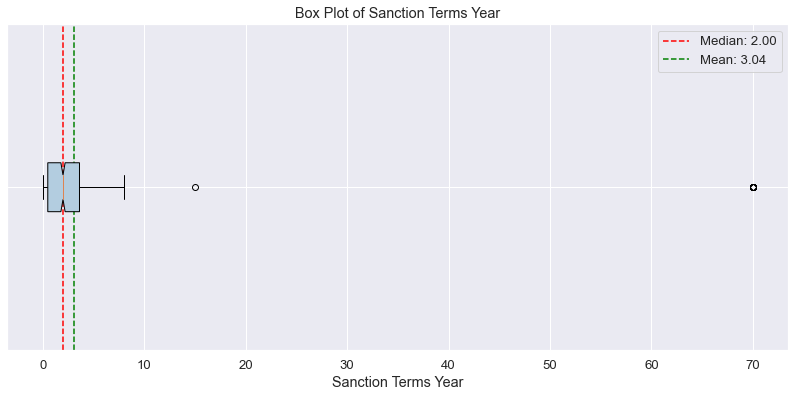

In [34]:
# Cheking outliers 

plt.figure(figsize=(14,6))

box_plot = plt.boxplot(df['sanction_terms_year'], patch_artist=True, notch=True, vert=False)
colors = ['#b3cde0', '#6497b1']
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)

median = df['sanction_terms_year'].median()
mean = df['sanction_terms_year'].mean()
plt.axvline(median, color='red', linestyle='--', label='Median: {:.2f}'.format(median))
plt.axvline(mean, color='green', linestyle='--', label='Mean: {:.2f}'.format(mean))

plt.title('Box Plot of Sanction Terms Year')
plt.xlabel('Sanction Terms Year')
plt.yticks([1], [''])
plt.legend()

plt.show()

In [35]:
# get the outliers
q1 = np.percentile(df['sanction_terms_year'], 25)
q3 = np.percentile(df['sanction_terms_year'], 75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
outliers = df[(df['sanction_terms_year'] < lower_bound) | (df['sanction_terms_year'] > upper_bound)]

print('Outliers in sanction_terms_year:')
print(outliers.shape)
outliers

Outliers in sanction_terms_year:
(10, 7)


,sport,substance_reason,sanction_terms,sanction_announced,month,year,sanction_terms_year
12,Rowing,Non-Analytical: Possession and Use/Attempted U...,Lifetime Suspension,2021-05-13,May,2021,70.0
159,Mixed Martial Arts,Methyltestosterone; Stanozolol,Lifetime Suspension,2019-04-01,April,2019,70.0
279,Track and Field - Athlete Support Personnel,"Non-Analytical: Possession, Adminstration and ...",Lifetime,2017-11-08,November,2017,70.0
440,Tennis,"Methenolone, Androst-(2,3)-en-17-one, and GHRP-6",15-Year Suspension - Loss of Results,2015-03-18,March,2015,15.0
442,Cycling - Athlete Support Personnel,"Non-Analytical: Possession, Trafficking, and A...",Lifetime Suspension,2015-01-22,January,2015,70.0
526,Cycling - Athlete Support Personnel,Non-Analytical,Lifetime Suspension,2012-07-10,July,2012,70.0
589,Track and Field - Athlete Support Personnel,Non-Analytical: Trafficking and Administering,Lifetime Suspension,2010-06-28,June,2010,70.0
631,Track and Field - Athlete Support Personnel,Non-Analytical,Lifetime Suspension,2008-07-15,July,2008,70.0
638,Cycling,Non-Analytical: Refusal to Submit to Sample Co...,Lifetime Suspension,2008-02-05,February,2008,70.0
649,Track and Field - Athlete Support Personnel,Non-Analytical,Lifetime Suspension,2007-03-12,March,2007,70.0


 As we see in output on the above code there are 10 outliers in sanction_terms_year,
 and we will delete them.

In [36]:
# Delete outliers

z = np.abs(stats.zscore(df['sanction_terms_year']))
threshold = 3
df = df[(z < threshold)]

In [37]:
df['loss_of_results'] = df['sanction_terms'].apply(lambda x: 1 if 'Loss of Results' in str(x) else 0)
df['loss_of_results'].value_counts()

1    338
0    212
Name: loss_of_results, dtype: int64

In [38]:
# After creating two valuable columns from "sanction_terms", 
# i want to delete this columns, beacuse now the column "sanction_terms" is not necessary.

df = df.drop('sanction_terms', axis=1)
df.head(10)

,sport,substance_reason,sanction_announced,month,year,sanction_terms_year,loss_of_results
0,Cycling,Androgenic Anabolic Steroid,2021-08-11,August,2021,4.000000,0
1,Weightlifting,Stanozolol,2021-08-11,August,2021,4.000000,0
2,Pentathlon,Ostarine; LGD?4033; GW1516,2021-08-06,August,2021,6.000000,0
3,Mixed Martial Arts,Cocaine,2021-07-29,July,2021,0.083333,0
4,Track and Field,Cannabinoids,2021-07-02,July,2021,0.083333,0
5,Weightlifting,Dehydrochloromethyltestosterone (DHCMT),2021-07-01,July,2021,4.000000,0
6,Paralympic Track and Field,Ostarine; LGD?4033,2021-06-29,June,2021,1.000000,0
7,Mixed Martial Arts,Stanozolol,2021-06-16,June,2021,1.500000,0
8,Paralympic Judo,Non-Analytical: Refusal to Submit to Sample Co...,2021-06-16,June,2021,4.000000,0
9,Weightlifting,Oxymetholone; Dehydrochloromethyltestosterone ...,2021-06-03,June,2021,4.000000,0


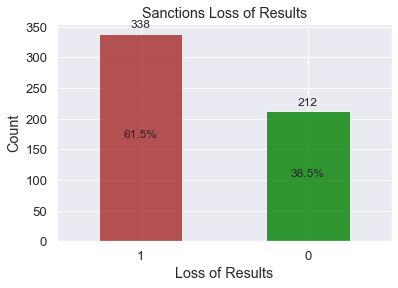

In [39]:
# count values and plot bar chart
counts = df['loss_of_results'].value_counts()
ax = counts.plot(kind='bar', color=['brown', 'green'], alpha=0.8, rot=0)
ax.set_xlabel('Loss of Results')
ax.set_ylabel('Count')
ax.set_title('Sanctions Loss of Results')

total = counts.sum()
for i, v in enumerate(counts):
    ax.text(i, v+10, str(v), ha='center', fontsize=12)

for i, v in enumerate(counts):
    ax.text(i, v/2, f"{v/total:.1%}", ha='center', fontsize=12)

plt.show()

In [ ]:
# Tableau interface PyGWalker
    
import pygwalker as pg
gwalker = pg.walk(df)

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 550 entries, 0 to 662
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   sport                550 non-null    object        
 1   substance_reason     550 non-null    object        
 2   sanction_announced   550 non-null    datetime64[ns]
 3   month                550 non-null    object        
 4   year                 550 non-null    int64         
 5   sanction_terms_year  550 non-null    float64       
 6   loss_of_results      550 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 34.4+ KB


In [42]:
df.head()

,sport,substance_reason,sanction_announced,month,year,sanction_terms_year,loss_of_results
0,Cycling,Androgenic Anabolic Steroid,2021-08-11,August,2021,4.000000,0
1,Weightlifting,Stanozolol,2021-08-11,August,2021,4.000000,0
2,Pentathlon,Ostarine; LGD?4033; GW1516,2021-08-06,August,2021,6.000000,0
3,Mixed Martial Arts,Cocaine,2021-07-29,July,2021,0.083333,0
4,Track and Field,Cannabinoids,2021-07-02,July,2021,0.083333,0


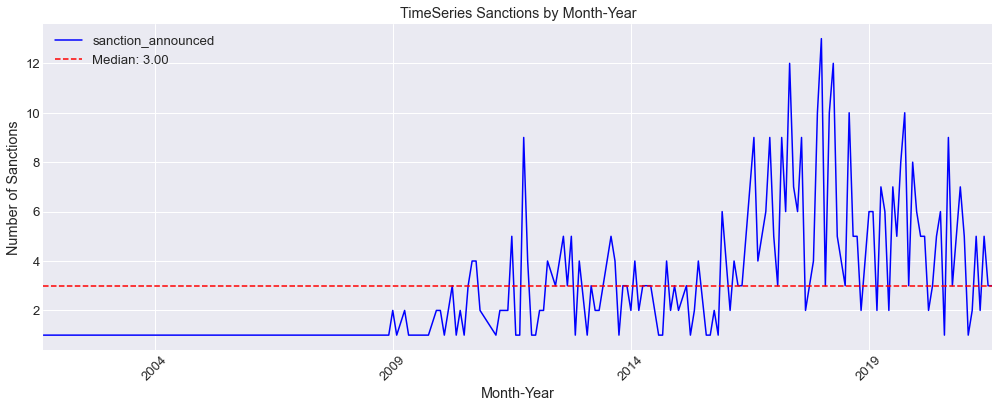

In [43]:
# Plot time series

plt.figure(figsize=(17, 6))
plt.style.use('seaborn-darkgrid')

sanctions_by_month_year = df.groupby(df['sanction_announced'].dt.to_period('M'))['sanction_announced'].count()

ax = sanctions_by_month_year.plot(color='blue')
median = sanctions_by_month_year.median()
ax.axhline(y=median, color='red', linestyle='--', label=f'Median: {median:.2f}')
ax.set_xlabel('Month-Year')
ax.set_ylabel('Number of Sanctions')
ax.set_title('TimeSeries Sanctions by Month-Year')
plt.xticks(rotation=45)

ax.legend()
plt.show()

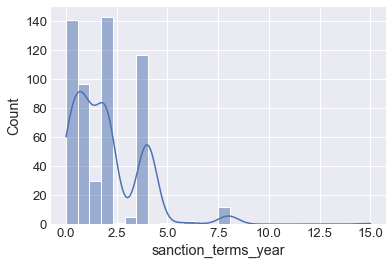

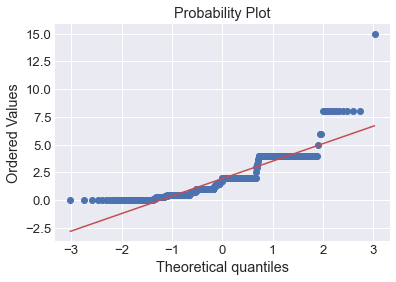

In [44]:
sns.histplot(df['sanction_terms_year'], kde=True)
fig = plt.figure()
res = stats.probplot(df['sanction_terms_year'], plot=plt)
plt.show()

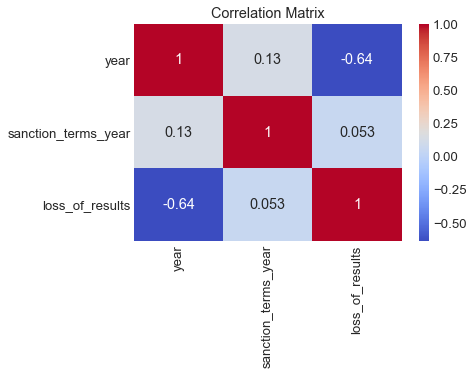

In [45]:
corr = df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

A negative correlation coefficient between year and loss_of_results (-0.64) means that as the year increases, the loss_of_results tends to decrease, and vice versa. This could suggest that as time passes, there are more advanced methods for detecting doping, leading to fewer cases of loss of results.

A positive correlation coefficient between sanction_terms_year and loss_of_results (0.053) means that as the value of sanction_terms_year increases, the loss_of_results tends to increase, and vice versa. This suggests that longer sanction terms are associated with more severe consequences, such as loss of results.

A positive correlation coefficient between sanction_terms_year and year (0.13) means that as the year increases, the value of sanction_terms_year tends to increase, and vice versa. This could suggest that over time, the authorities have increased the severity of sanctions for doping violations.

In [46]:
# After this manipulations in dataset we can encode some categorical columns to numeric 
# and get data ready and valuable to modeling.

In [47]:
# Create a new dataframe with the encoded variables

df_encode = df.copy()
le = LabelEncoder()
df_encode['sport_encoded'] = le.fit_transform(df_encode['sport'])
df_encode['substance_reason_encoded'] = le.fit_transform(df_encode['substance_reason'])
df_encode['month_encoded'] = le.fit_transform(df_encode['month'])+1   # plus 1 is for starting numeric value from 1 not from 0

df_encode.drop(['sport', 'substance_reason', 'month'], axis=1, inplace=True)
df_encode.head(5)

,sanction_announced,year,sanction_terms_year,loss_of_results,sport_encoded,substance_reason_encoded,month_encoded
0,2021-08-11,2021,4.000000,0,9,24,2
1,2021-08-11,2021,4.000000,0,59,211,2
2,2021-08-06,2021,6.000000,0,35,196,2
3,2021-07-29,2021,0.083333,0,20,61,6
4,2021-07-02,2021,0.083333,0,54,45,6


In [ ]:
df_encode.info()

In [49]:
for col in df_encode.columns:
    print(col, ':', df_encode[col].nunique())

sanction_announced : 515
year : 19
sanction_terms_year : 32
loss_of_results : 2
sport_encoded : 62
substance_reason_encoded : 227
month_encoded : 12


## Modeling, Validating, Predicting

In [51]:
# Set X and y
X = df_encode.drop(['loss_of_results', 'sanction_announced'], axis=1)
y = df_encode['loss_of_results']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit a logistic regression model to the training data
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

# Predict on the test set
y_pred = lr_model.predict(X_test)

# Print confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Calculate and print accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

[[ 0 45]
 [ 1 64]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        45
           1       0.59      0.98      0.74        65

    accuracy                           0.58       110
   macro avg       0.29      0.49      0.37       110
weighted avg       0.35      0.58      0.43       110

Accuracy: 0.5818181818181818


The accuracy of the model is 0.5818181818181818. The confusion matrix shows that the model correctly predicted 64 out of 65 instances of loss of results (true positives) 
but incorrectly predicted 45 instances as not having loss of results (false negatives). The precision of the model for predicting loss of results is 0.59, 
meaning that out of all the instances it predicted as having loss of results, only 59% were actually true positives. The recall of the model is 0.98, 
indicating that out of all the instances with loss of results, it correctly identified 98% of them. The f1-score is 0.74, which is the harmonic mean of precision and recall. 
The macro-average f1-score is 0.37, and the weighted-average f1-score is 0.43, 
indicating that the model is not performing very well overall.

The confusion matrix shows that the logistic regression model correctly predicted 64 out of 65 cases where a loss of results occurred, but incorrectly predicted that there would be no loss of results in all 45 cases where there actually was one.

The precision for class 1 (the positive class indicating the occurrence of a loss of results) is 0.59, which means that out of all the cases that the model predicted to be positive, 59% of them actually were. The recall for class 1 is 0.98, which means that out of all the actual positive cases, the model correctly identified 98% of them.

The low precision for class 0 (the negative class indicating no loss of results) means that out of all the cases the model predicted to be negative, almost none of them actually were. The overall accuracy of the model is 0.58, which means that it correctly classified 58% of the cases in the test set.

In summary, while the model performs well in identifying the cases where a loss of results occurs, it struggles to correctly identify cases where there is no loss of results.

In [52]:
# Set X and y
X = df_encode.drop(['loss_of_results', 'sanction_announced'], axis=1)
y = df_encode['loss_of_results']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Create a Gradient Boosting Classifier model
gb_model = GradientBoostingClassifier(random_state=42)

# Train the model
gb_model.fit(X_train, y_train)

# Make predictions
y_pred = gb_model.predict(X_test)

# Print the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Calculate accuracy score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

[[42  3]
 [ 3 62]]
              precision    recall  f1-score   support

           0       0.93      0.93      0.93        45
           1       0.95      0.95      0.95        65

    accuracy                           0.95       110
   macro avg       0.94      0.94      0.94       110
weighted avg       0.95      0.95      0.95       110

Accuracy: 0.9454545454545454


Using boosting with the XGBoost classifier has significantly improved the model's accuracy in identifying both positive and negative cases. The accuracy score for class 0, which was previously low, has increased to 0.93, indicating that the model is now performing well in identifying cases where there is no loss of results. The overall accuracy score has increased to 0.95, which is a significant improvement over the logistic regression model

The boosting model shows a significant improvement in the accuracy score for class 0 (no loss of results). It correctly identifies 42 out of 45 cases where there is no loss of results, resulting in a precision of 0.93 and recall of 0.93. The overall accuracy of the model is also high at 0.95. This suggests that the boosting algorithm has been able to better learn the patterns in the data and make more accurate predictions.

In [53]:
X = df_encode.drop(['loss_of_results', 'sanction_announced'], axis=1)
y = df_encode['loss_of_results']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Next, we can build our model:

bagging = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=100, random_state=42)
bagging.fit(X_train, y_train)

y_pred = bagging.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))


[[56  3]
 [10 96]]
              precision    recall  f1-score   support

           0       0.85      0.95      0.90        59
           1       0.97      0.91      0.94       106

    accuracy                           0.92       165
   macro avg       0.91      0.93      0.92       165
weighted avg       0.93      0.92      0.92       165

Accuracy: 0.9212121212121213


In [54]:
# define the models
lr = LogisticRegression(random_state=42)
xgb = XGBClassifier(random_state=42)
bc = BaggingClassifier(random_state=42)

# perform cross-validation
cv_scores_lr = cross_val_score(lr, X, y, cv=5)
cv_scores_xgb = cross_val_score(xgb, X, y, cv=5)
cv_scores_bc = cross_val_score(bc, X, y, cv=5)

# print the results
print("Logistic Regression: ", cv_scores_lr.mean())
print("XGBoost: ", cv_scores_xgb.mean())
print("Bagging Classifier: ", cv_scores_bc.mean())

[11:47:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:47:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:47:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:47:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel